# 📈 Complete Portfolio Trading Strategy with Backtest & Metrics

## Week 18: Portfolio Optimization - Trading Strategy Implementation

This notebook implements a **complete portfolio trading strategy** from signal generation to backtesting and performance evaluation.

### What We'll Cover:
1. **Data Acquisition** - Multi-asset price data collection
2. **Signal Generation** - Technical indicators and trading rules
3. **Portfolio Optimization** - Mean-variance and risk parity allocation
4. **Backtesting Engine** - Realistic simulation with costs
5. **Performance Metrics** - Sharpe, Sortino, Drawdown, CAGR
6. **Risk Analysis** - VaR, CVaR, rolling volatility
7. **Visualization** - Equity curves, drawdowns, comparisons

---

## 1. Import Required Libraries

In [1]:
# Core libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Data acquisition
import yfinance as yf

# Optimization
from scipy.optimize import minimize
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Random seed for reproducibility
np.random.seed(42)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Load and Prepare Market Data

We'll build a diversified portfolio across multiple asset classes:
- **US Equities**: SPY (S&P 500), QQQ (Nasdaq), IWM (Russell 2000)
- **International**: EFA (Developed Markets), EEM (Emerging Markets)
- **Fixed Income**: TLT (Long-term Treasuries), IEF (Intermediate Treasuries)
- **Alternatives**: GLD (Gold), VNQ (REITs)

In [2]:
# Define universe of assets
TICKERS = ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'TLT', 'IEF', 'GLD', 'VNQ']
BENCHMARK = 'SPY'

# Download data
START_DATE = '2015-01-01'
END_DATE = '2024-12-31'

print(f"📥 Downloading data for {len(TICKERS)} assets from {START_DATE} to {END_DATE}...")

# Download adjusted close prices (auto_adjust=True returns 'Close' as adjusted)
data = yf.download(TICKERS, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)['Close']
benchmark_data = yf.download(BENCHMARK, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)['Close']

# Handle missing data
data = data.dropna()
benchmark_data = benchmark_data.loc[data.index]

print(f"✅ Data loaded: {len(data)} trading days")
print(f"📅 Date range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
data.head()

📥 Downloading data for 9 assets from 2015-01-01 to 2024-12-31...
✅ Data loaded: 2515 trading days
📅 Date range: 2015-01-02 to 2024-12-30


Ticker,EEM,EFA,GLD,IEF,IWM,QQQ,SPY,TLT,VNQ
Date,,,,,,,,,
2015-01-02,30.355051,43.780636,114.080002,83.933128,102.969826,94.784424,170.589691,94.760460,53.111637
2015-01-05,29.814817,42.747185,115.800003,84.445236,101.593170,93.394081,167.508835,96.249001,53.402298
2015-01-06,29.689539,42.262981,117.120003,85.012581,99.835609,92.141808,165.931061,97.983086,53.931995
2015-01-07,30.331564,42.732731,116.430000,84.996788,101.065079,93.329620,167.998764,97.789604,54.758842
2015-01-08,30.848312,43.310886,115.940002,84.650124,102.779327,95.115913,170.979950,96.494560,54.965557


In [3]:
# Calculate returns
returns = data.pct_change().dropna()
log_returns = np.log(data / data.shift(1)).dropna()
benchmark_returns = benchmark_data.pct_change().dropna()

# Summary statistics
print("📊 Return Statistics (Annualized):\n")
summary = pd.DataFrame({
    'Mean Return': returns.mean() * 252,
    'Volatility': returns.std() * np.sqrt(252),
    'Sharpe Ratio': (returns.mean() * 252) / (returns.std() * np.sqrt(252)),
    'Skewness': returns.skew(),
    'Kurtosis': returns.kurtosis()
}).round(3)
summary

📊 Return Statistics (Annualized):



,Mean Return,Volatility,Sharpe Ratio,Skewness,Kurtosis
Ticker,,,,,
EEM,0.052,0.207,0.249,-0.533,7.790
EFA,0.066,0.173,0.384,-0.928,13.251
GLD,0.085,0.141,0.600,-0.105,2.750
IEF,0.008,0.067,0.124,0.166,3.081
IWM,0.101,0.225,0.448,-0.574,8.011
QQQ,0.193,0.218,0.885,-0.381,6.285
SPY,0.139,0.176,0.786,-0.555,12.749
TLT,-0.000,0.153,-0.002,0.112,4.521
VNQ,0.069,0.208,0.331,-1.114,20.311


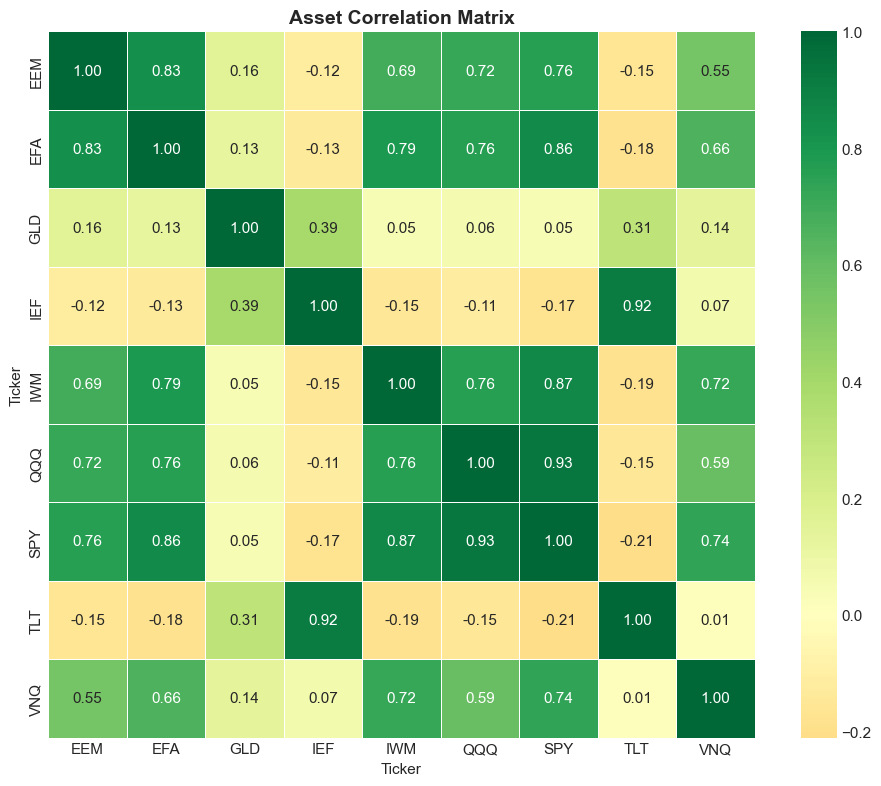


💡 Key Insight: Low correlations between asset classes enable diversification benefits.


In [4]:
# Correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix = returns.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Asset Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Key Insight: Low correlations between asset classes enable diversification benefits.")

## 3. Define Trading Signals

We'll implement multiple signal types:
1. **Trend Following**: Moving average crossovers
2. **Momentum**: Rate of change and RSI
3. **Mean Reversion**: Bollinger Bands
4. **Composite Signal**: Weighted combination

In [5]:
class TradingSignals:
    """Generate trading signals for portfolio construction."""
    
    def __init__(self, prices: pd.DataFrame):
        self.prices = prices
        self.returns = prices.pct_change()
        
    def moving_average_signal(self, short_window: int = 20, long_window: int = 50) -> pd.DataFrame:
        """
        Trend following: SMA crossover signal.
        +1 when short MA > long MA, -1 otherwise
        """
        sma_short = self.prices.rolling(window=short_window).mean()
        sma_long = self.prices.rolling(window=long_window).mean()
        signal = np.where(sma_short > sma_long, 1, -1)
        return pd.DataFrame(signal, index=self.prices.index, columns=self.prices.columns)
    
    def momentum_signal(self, lookback: int = 20) -> pd.DataFrame:
        """
        Momentum: Rank assets by past returns.
        Scaled between -1 and +1
        """
        momentum = self.prices.pct_change(lookback)
        # Rank and scale to [-1, 1]
        ranked = momentum.rank(axis=1, pct=True) * 2 - 1
        return ranked.fillna(0)
    
    def rsi_signal(self, period: int = 14, oversold: int = 30, overbought: int = 70) -> pd.DataFrame:
        """
        RSI-based mean reversion signal.
        +1 when oversold, -1 when overbought, 0 otherwise
        """
        delta = self.prices.diff()
        gain = delta.where(delta > 0, 0).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        
        signal = pd.DataFrame(0, index=self.prices.index, columns=self.prices.columns)
        signal[rsi < oversold] = 1   # Buy signal
        signal[rsi > overbought] = -1  # Sell signal
        return signal
    
    def volatility_signal(self, lookback: int = 20) -> pd.DataFrame:
        """
        Inverse volatility signal: Lower weight to high vol assets.
        """
        vol = self.returns.rolling(window=lookback).std()
        inv_vol = 1 / vol
        # Normalize to sum to 1 (for positive signals)
        inv_vol_scaled = inv_vol.div(inv_vol.sum(axis=1), axis=0)
        return inv_vol_scaled.fillna(0)
    
    def composite_signal(self, weights: dict = None) -> pd.DataFrame:
        """
        Combine multiple signals with specified weights.
        """
        if weights is None:
            weights = {'ma': 0.4, 'momentum': 0.3, 'rsi': 0.2, 'vol': 0.1}
        
        ma_sig = self.moving_average_signal()
        mom_sig = self.momentum_signal()
        rsi_sig = self.rsi_signal()
        vol_sig = self.volatility_signal()
        
        composite = (weights['ma'] * ma_sig + 
                    weights['momentum'] * mom_sig + 
                    weights['rsi'] * rsi_sig +
                    weights['vol'] * vol_sig)
        
        return composite

# Initialize signals generator
signals = TradingSignals(data)
print("✅ TradingSignals class initialized")

✅ TradingSignals class initialized


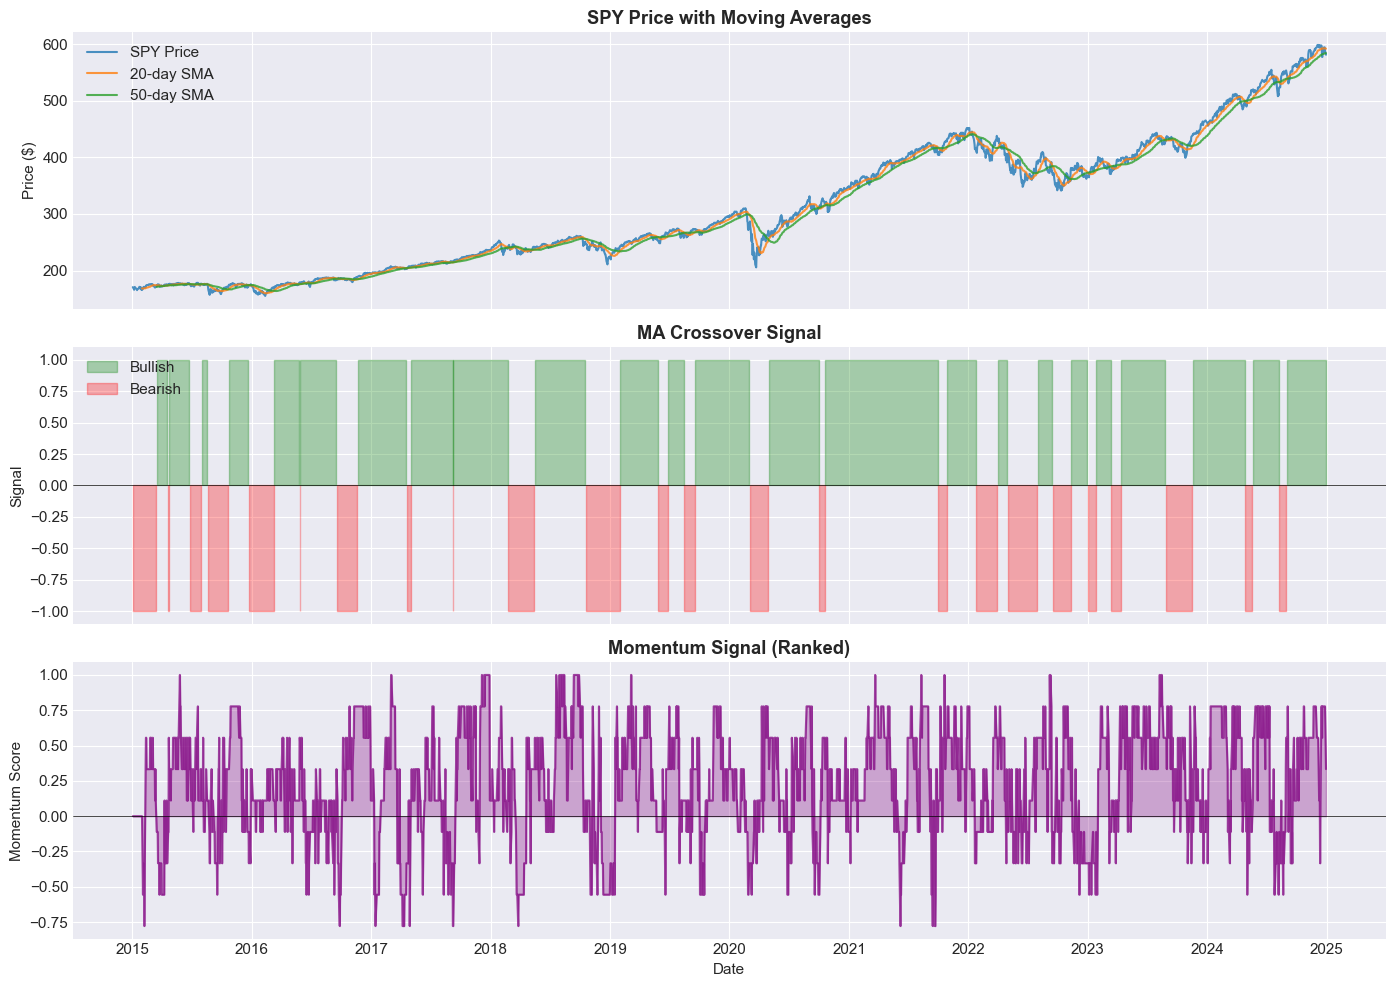

In [6]:
# Generate and visualize signals for SPY
ma_signal = signals.moving_average_signal()
mom_signal = signals.momentum_signal()

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Price with moving averages
ax1 = axes[0]
ax1.plot(data['SPY'], label='SPY Price', alpha=0.8)
ax1.plot(data['SPY'].rolling(20).mean(), label='20-day SMA', alpha=0.8)
ax1.plot(data['SPY'].rolling(50).mean(), label='50-day SMA', alpha=0.8)
ax1.set_ylabel('Price ($)')
ax1.legend(loc='upper left')
ax1.set_title('SPY Price with Moving Averages', fontweight='bold')

# MA Crossover Signal
ax2 = axes[1]
ax2.fill_between(ma_signal.index, ma_signal['SPY'], 0, 
                  where=ma_signal['SPY'] > 0, color='green', alpha=0.3, label='Bullish')
ax2.fill_between(ma_signal.index, ma_signal['SPY'], 0, 
                  where=ma_signal['SPY'] < 0, color='red', alpha=0.3, label='Bearish')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('Signal')
ax2.legend(loc='upper left')
ax2.set_title('MA Crossover Signal', fontweight='bold')

# Momentum Signal
ax3 = axes[2]
ax3.plot(mom_signal['SPY'], color='purple', alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.fill_between(mom_signal.index, mom_signal['SPY'], 0, alpha=0.3, color='purple')
ax3.set_ylabel('Momentum Score')
ax3.set_xlabel('Date')
ax3.set_title('Momentum Signal (Ranked)', fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Build Portfolio Allocation Strategy

We'll implement three portfolio optimization approaches:
1. **Mean-Variance Optimization (MVO)** - Markowitz framework
2. **Risk Parity** - Equal risk contribution
3. **Minimum Variance** - Risk minimization

In [7]:
class PortfolioOptimizer:
    """Portfolio optimization methods."""
    
    def __init__(self, returns: pd.DataFrame, risk_free_rate: float = 0.02):
        self.returns = returns
        self.n_assets = len(returns.columns)
        self.assets = returns.columns.tolist()
        self.rf = risk_free_rate / 252  # Daily risk-free rate
        
    def portfolio_stats(self, weights: np.ndarray) -> tuple:
        """Calculate portfolio return and volatility."""
        port_return = np.sum(self.returns.mean() * weights) * 252
        port_vol = np.sqrt(np.dot(weights.T, np.dot(self.returns.cov() * 252, weights)))
        return port_return, port_vol
    
    def sharpe_ratio(self, weights: np.ndarray) -> float:
        """Calculate Sharpe ratio."""
        port_return, port_vol = self.portfolio_stats(weights)
        return (port_return - self.rf * 252) / port_vol
    
    def negative_sharpe(self, weights: np.ndarray) -> float:
        """Negative Sharpe for minimization."""
        return -self.sharpe_ratio(weights)
    
    def portfolio_volatility(self, weights: np.ndarray) -> float:
        """Portfolio volatility."""
        return np.sqrt(np.dot(weights.T, np.dot(self.returns.cov() * 252, weights)))
    
    def mean_variance_optimize(self, target: str = 'sharpe') -> np.ndarray:
        """
        Mean-Variance Optimization.
        target: 'sharpe' (maximize), 'min_vol' (minimum variance)
        """
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0, 1) for _ in range(self.n_assets))
        init_weights = np.array([1/self.n_assets] * self.n_assets)
        
        if target == 'sharpe':
            result = minimize(self.negative_sharpe, init_weights, 
                            method='SLSQP', bounds=bounds, constraints=constraints)
        else:  # min_vol
            result = minimize(self.portfolio_volatility, init_weights,
                            method='SLSQP', bounds=bounds, constraints=constraints)
        return result.x
    
    def risk_parity(self) -> np.ndarray:
        """
        Risk Parity: Equal risk contribution from each asset.
        """
        cov_matrix = self.returns.cov() * 252
        
        def risk_contribution(weights):
            port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            marginal_contrib = np.dot(cov_matrix, weights)
            risk_contrib = weights * marginal_contrib / port_vol
            return risk_contrib
        
        def risk_parity_objective(weights):
            rc = risk_contribution(weights)
            target_risk = 1 / self.n_assets
            return np.sum((rc - target_risk) ** 2)
        
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0.01, 1) for _ in range(self.n_assets))
        init_weights = np.array([1/self.n_assets] * self.n_assets)
        
        result = minimize(risk_parity_objective, init_weights,
                         method='SLSQP', bounds=bounds, constraints=constraints)
        return result.x
    
    def inverse_volatility(self) -> np.ndarray:
        """Simple inverse volatility weighting."""
        vol = self.returns.std() * np.sqrt(252)
        inv_vol = 1 / vol
        return (inv_vol / inv_vol.sum()).values
    
    def equal_weight(self) -> np.ndarray:
        """Equal weight allocation."""
        return np.array([1/self.n_assets] * self.n_assets)
    
    def efficient_frontier(self, n_points: int = 100) -> pd.DataFrame:
        """Generate efficient frontier points."""
        target_returns = np.linspace(
            self.returns.mean().min() * 252,
            self.returns.mean().max() * 252,
            n_points
        )
        
        frontier = []
        for target_ret in target_returns:
            constraints = [
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                {'type': 'eq', 'fun': lambda x: np.sum(self.returns.mean() * x) * 252 - target_ret}
            ]
            bounds = tuple((0, 1) for _ in range(self.n_assets))
            init_weights = np.array([1/self.n_assets] * self.n_assets)
            
            result = minimize(self.portfolio_volatility, init_weights,
                            method='SLSQP', bounds=bounds, constraints=constraints)
            
            if result.success:
                frontier.append({
                    'return': target_ret,
                    'volatility': result.fun,
                    'sharpe': (target_ret - self.rf * 252) / result.fun
                })
        
        return pd.DataFrame(frontier)

# Initialize optimizer
optimizer = PortfolioOptimizer(returns)
print("✅ PortfolioOptimizer class initialized")

✅ PortfolioOptimizer class initialized


📊 Portfolio Weights Comparison:

     Max Sharpe  Min Variance  Risk Parity  Inv Volatility  Equal Weight
SPY      0.0000        0.0000       0.1621          0.0825        0.1111
QQQ      0.0000        0.0459       0.1246          0.0987        0.1111
IWM      0.4547        0.0034       0.0100          0.1208        0.1111
EFA      0.0000        0.8246       0.0100          0.2537        0.1111
EEM      0.0000        0.0000       0.1983          0.0758        0.1111
TLT      0.5453        0.0000       0.1884          0.0782        0.1111
IEF      0.0000        0.1260       0.1491          0.0968        0.1111
GLD      0.0000        0.0000       0.0100          0.1114        0.1111
VNQ      0.0000        0.0000       0.1475          0.0819        0.1111


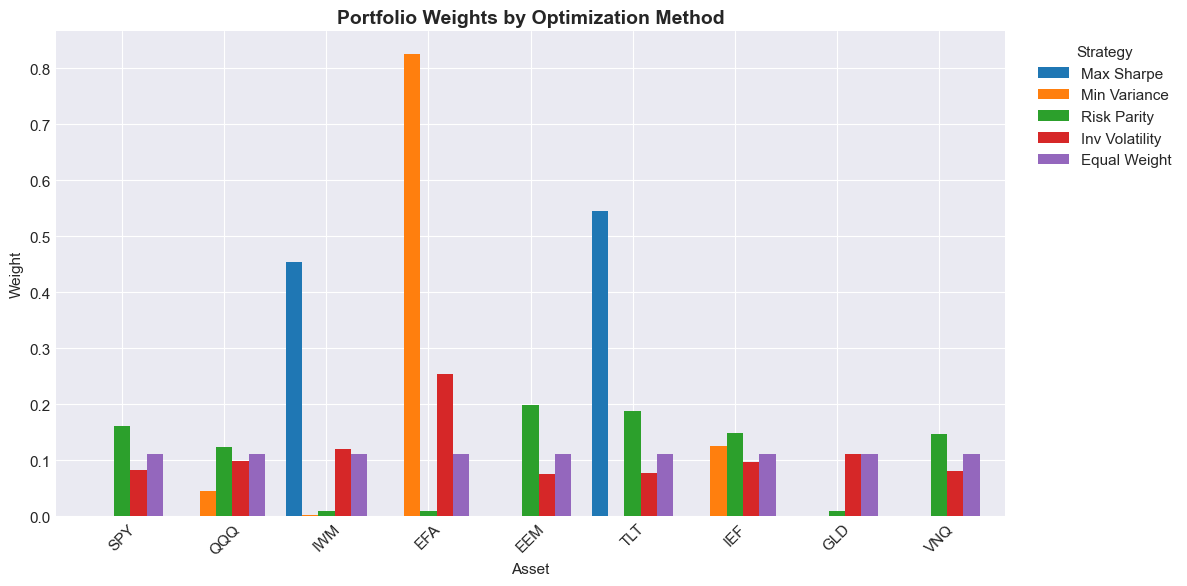

In [8]:
# Calculate optimal weights using different methods
weights_mvo = optimizer.mean_variance_optimize(target='sharpe')
weights_min_vol = optimizer.mean_variance_optimize(target='min_vol')
weights_risk_parity = optimizer.risk_parity()
weights_inv_vol = optimizer.inverse_volatility()
weights_equal = optimizer.equal_weight()

# Create comparison DataFrame
weights_df = pd.DataFrame({
    'Max Sharpe': weights_mvo,
    'Min Variance': weights_min_vol,
    'Risk Parity': weights_risk_parity,
    'Inv Volatility': weights_inv_vol,
    'Equal Weight': weights_equal
}, index=TICKERS).round(4)

print("📊 Portfolio Weights Comparison:\n")
print(weights_df.to_string())

# Visualize weights
fig, ax = plt.subplots(figsize=(12, 6))
weights_df.plot(kind='bar', ax=ax, width=0.8)
plt.title('Portfolio Weights by Optimization Method', fontsize=14, fontweight='bold')
plt.xlabel('Asset')
plt.ylabel('Weight')
plt.legend(title='Strategy', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

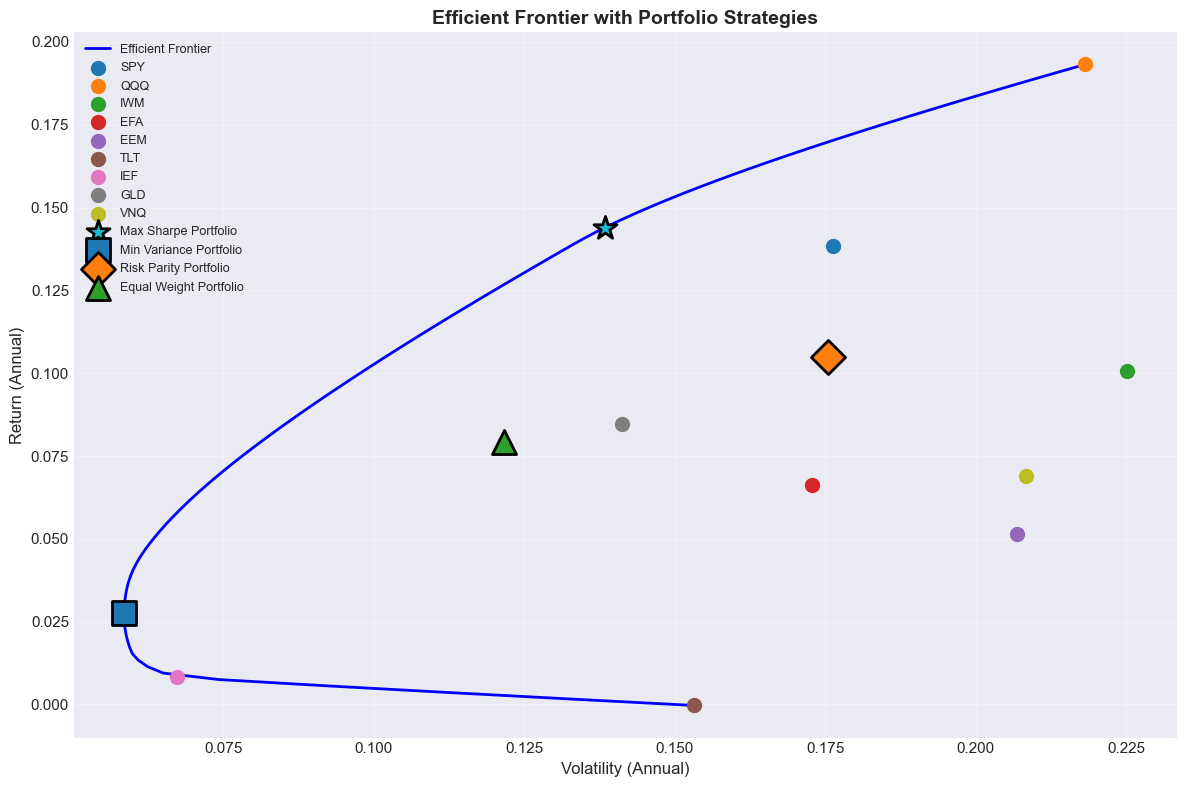

In [9]:
# Plot Efficient Frontier
frontier = optimizer.efficient_frontier()

fig, ax = plt.subplots(figsize=(12, 8))

# Plot efficient frontier
ax.plot(frontier['volatility'], frontier['return'], 'b-', linewidth=2, label='Efficient Frontier')

# Plot individual assets
for i, asset in enumerate(TICKERS):
    asset_ret = returns[asset].mean() * 252
    asset_vol = returns[asset].std() * np.sqrt(252)
    ax.scatter(asset_vol, asset_ret, s=100, marker='o', label=asset, zorder=5)

# Plot portfolio strategies
strategies = {
    'Max Sharpe': weights_mvo,
    'Min Variance': weights_min_vol,
    'Risk Parity': weights_risk_parity,
    'Equal Weight': weights_equal
}

markers = ['*', 's', 'D', '^']
for (name, w), marker in zip(strategies.items(), markers):
    ret, vol = optimizer.portfolio_stats(w)
    ax.scatter(vol, ret, s=300, marker=marker, edgecolors='black', linewidths=2, 
               label=f'{name} Portfolio', zorder=10)

ax.set_xlabel('Volatility (Annual)', fontsize=12)
ax.set_ylabel('Return (Annual)', fontsize=12)
ax.set_title('Efficient Frontier with Portfolio Strategies', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Implement Backtesting Engine

A comprehensive backtesting framework with:
- Rolling window optimization
- Transaction cost modeling
- Rebalancing frequency control
- Portfolio value tracking

In [10]:
class Backtester:
    """
    Portfolio backtesting engine with rolling optimization.
    """
    
    def __init__(self, prices: pd.DataFrame, returns: pd.DataFrame,
                 initial_capital: float = 100000,
                 transaction_cost: float = 0.001,  # 10 bps per trade
                 rebalance_freq: int = 21,  # Monthly rebalancing
                 lookback_window: int = 252):  # 1 year lookback
        
        self.prices = prices
        self.returns = returns
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost
        self.rebalance_freq = rebalance_freq
        self.lookback = lookback_window
        self.n_assets = len(prices.columns)
        
    def run_backtest(self, strategy: str = 'risk_parity', 
                     signal_weights: pd.DataFrame = None) -> dict:
        """
        Run backtest for a given strategy.
        
        strategy: 'max_sharpe', 'min_vol', 'risk_parity', 'inv_vol', 'equal', 'signal_weighted'
        """
        dates = self.returns.index[self.lookback:]
        n_days = len(dates)
        
        # Initialize tracking arrays
        portfolio_value = np.zeros(n_days)
        portfolio_value[0] = self.initial_capital
        
        weights_history = []
        turnover_history = []
        
        current_weights = np.array([1/self.n_assets] * self.n_assets)
        
        for i, date in enumerate(dates):
            # Check if rebalancing day
            if i % self.rebalance_freq == 0:
                # Get lookback returns
                lookback_start = self.returns.index.get_loc(date) - self.lookback
                lookback_end = self.returns.index.get_loc(date)
                lookback_returns = self.returns.iloc[lookback_start:lookback_end]
                
                # Calculate new optimal weights
                optimizer = PortfolioOptimizer(lookback_returns)
                
                if strategy == 'max_sharpe':
                    new_weights = optimizer.mean_variance_optimize(target='sharpe')
                elif strategy == 'min_vol':
                    new_weights = optimizer.mean_variance_optimize(target='min_vol')
                elif strategy == 'risk_parity':
                    new_weights = optimizer.risk_parity()
                elif strategy == 'inv_vol':
                    new_weights = optimizer.inverse_volatility()
                elif strategy == 'equal':
                    new_weights = optimizer.equal_weight()
                elif strategy == 'signal_weighted' and signal_weights is not None:
                    # Use signal-based weights
                    sig = signal_weights.loc[date].values
                    sig_pos = np.maximum(sig, 0)  # Only long positions
                    if sig_pos.sum() > 0:
                        new_weights = sig_pos / sig_pos.sum()
                    else:
                        new_weights = current_weights
                else:
                    new_weights = current_weights
                
                # Calculate turnover and transaction costs
                turnover = np.sum(np.abs(new_weights - current_weights))
                turnover_history.append(turnover)
                
                # Apply transaction costs
                if i > 0:
                    cost = turnover * self.transaction_cost * portfolio_value[i-1]
                    portfolio_value[i-1] -= cost
                
                current_weights = new_weights
            
            weights_history.append(current_weights.copy())
            
            # Calculate portfolio return for this day
            day_returns = self.returns.loc[date].values
            portfolio_return = np.dot(current_weights, day_returns)
            
            if i > 0:
                portfolio_value[i] = portfolio_value[i-1] * (1 + portfolio_return)
            else:
                portfolio_value[i] = self.initial_capital * (1 + portfolio_return)
            
            # Update weights due to price drift
            current_weights = current_weights * (1 + day_returns)
            current_weights = current_weights / current_weights.sum()
        
        return {
            'dates': dates,
            'portfolio_value': portfolio_value,
            'weights_history': np.array(weights_history),
            'turnover_history': turnover_history,
            'strategy': strategy
        }

# Initialize backtester
backtester = Backtester(data, returns, initial_capital=100000, 
                        transaction_cost=0.001, rebalance_freq=21)
print("✅ Backtester initialized")

✅ Backtester initialized


In [11]:
# Run backtests for all strategies
print("🔄 Running backtests for all strategies...")

strategies = ['max_sharpe', 'min_vol', 'risk_parity', 'inv_vol', 'equal']
backtest_results = {}

for strategy in strategies:
    print(f"  • Running {strategy}...")
    backtest_results[strategy] = backtester.run_backtest(strategy=strategy)

# Calculate benchmark (buy & hold SPY)
benchmark_start_idx = returns.index.get_loc(backtest_results['risk_parity']['dates'][0])
benchmark_prices = data['SPY'].iloc[benchmark_start_idx:]
benchmark_values = 100000 * benchmark_prices / benchmark_prices.iloc[0]

print("✅ All backtests completed!")

🔄 Running backtests for all strategies...
  • Running max_sharpe...
  • Running min_vol...
  • Running risk_parity...
  • Running inv_vol...
  • Running equal...
✅ All backtests completed!


## 6. Calculate Performance Metrics

Comprehensive performance analytics including:
- **Return Metrics**: Total Return, CAGR, Best/Worst periods
- **Risk Metrics**: Volatility, VaR, CVaR, Maximum Drawdown
- **Risk-Adjusted Metrics**: Sharpe, Sortino, Calmar ratios

In [12]:
class PerformanceMetrics:
    """Calculate comprehensive portfolio performance metrics."""
    
    def __init__(self, portfolio_values: np.ndarray, dates: pd.DatetimeIndex,
                 risk_free_rate: float = 0.02):
        self.values = portfolio_values
        self.dates = dates
        self.rf = risk_free_rate
        self.returns = pd.Series(portfolio_values).pct_change().dropna().values
        
    def total_return(self) -> float:
        """Total cumulative return."""
        return (self.values[-1] / self.values[0]) - 1
    
    def cagr(self) -> float:
        """Compound Annual Growth Rate."""
        n_years = len(self.values) / 252
        return (self.values[-1] / self.values[0]) ** (1 / n_years) - 1
    
    def annualized_volatility(self) -> float:
        """Annualized volatility."""
        return np.std(self.returns) * np.sqrt(252)
    
    def sharpe_ratio(self) -> float:
        """Annualized Sharpe Ratio."""
        excess_return = self.cagr() - self.rf
        return excess_return / self.annualized_volatility()
    
    def sortino_ratio(self) -> float:
        """Sortino Ratio (downside deviation)."""
        downside_returns = self.returns[self.returns < 0]
        downside_std = np.std(downside_returns) * np.sqrt(252)
        excess_return = self.cagr() - self.rf
        return excess_return / downside_std if downside_std > 0 else np.inf
    
    def max_drawdown(self) -> float:
        """Maximum Drawdown."""
        peak = np.maximum.accumulate(self.values)
        drawdown = (self.values - peak) / peak
        return np.min(drawdown)
    
    def calmar_ratio(self) -> float:
        """Calmar Ratio (CAGR / Max Drawdown)."""
        mdd = abs(self.max_drawdown())
        return self.cagr() / mdd if mdd > 0 else np.inf
    
    def var(self, confidence: float = 0.95) -> float:
        """Value at Risk (historical)."""
        return np.percentile(self.returns, (1 - confidence) * 100)
    
    def cvar(self, confidence: float = 0.95) -> float:
        """Conditional VaR (Expected Shortfall)."""
        var = self.var(confidence)
        return np.mean(self.returns[self.returns <= var])
    
    def win_rate(self) -> float:
        """Percentage of positive return days."""
        return np.mean(self.returns > 0)
    
    def profit_factor(self) -> float:
        """Ratio of gross profits to gross losses."""
        gains = np.sum(self.returns[self.returns > 0])
        losses = abs(np.sum(self.returns[self.returns < 0]))
        return gains / losses if losses > 0 else np.inf
    
    def drawdown_series(self) -> np.ndarray:
        """Calculate drawdown time series."""
        peak = np.maximum.accumulate(self.values)
        return (self.values - peak) / peak
    
    def all_metrics(self) -> dict:
        """Return all metrics as a dictionary."""
        return {
            'Total Return': f"{self.total_return():.2%}",
            'CAGR': f"{self.cagr():.2%}",
            'Volatility': f"{self.annualized_volatility():.2%}",
            'Sharpe Ratio': f"{self.sharpe_ratio():.2f}",
            'Sortino Ratio': f"{self.sortino_ratio():.2f}",
            'Max Drawdown': f"{self.max_drawdown():.2%}",
            'Calmar Ratio': f"{self.calmar_ratio():.2f}",
            'VaR (95%)': f"{self.var():.2%}",
            'CVaR (95%)': f"{self.cvar():.2%}",
            'Win Rate': f"{self.win_rate():.2%}",
            'Profit Factor': f"{self.profit_factor():.2f}"
        }

print("✅ PerformanceMetrics class defined")

✅ PerformanceMetrics class defined


In [13]:
# Calculate metrics for all strategies
print("📊 Performance Summary\n" + "="*80)

all_metrics = {}
for strategy, result in backtest_results.items():
    metrics = PerformanceMetrics(result['portfolio_value'], result['dates'])
    all_metrics[strategy] = metrics.all_metrics()

# Also calculate for benchmark
benchmark_metrics = PerformanceMetrics(benchmark_values.values, benchmark_values.index)
all_metrics['SPY Benchmark'] = benchmark_metrics.all_metrics()

# Create comparison table
metrics_df = pd.DataFrame(all_metrics).T
metrics_df.columns = ['Total Return', 'CAGR', 'Volatility', 'Sharpe', 'Sortino', 
                       'Max DD', 'Calmar', 'VaR', 'CVaR', 'Win Rate', 'Profit Factor']
print(metrics_df.to_string())
print("\n" + "="*80)

📊 Performance Summary
              Total Return    CAGR Volatility Sharpe Sortino   Max DD Calmar     VaR    CVaR Win Rate Profit Factor
max_sharpe          35.48%   3.44%     13.53%   0.11    0.13  -29.42%   0.12  -1.38%  -2.15%   55.06%          1.06
min_vol             27.87%   2.78%      6.10%   0.13    0.17  -21.31%   0.13  -0.60%  -0.90%   53.87%          1.09
risk_parity        155.36%  11.01%     18.29%   0.49    0.62  -32.29%   0.34  -1.76%  -2.73%   53.30%          1.13
inv_vol             76.22%   6.52%      9.81%   0.46    0.57  -24.04%   0.27  -0.90%  -1.46%   55.29%          1.14
equal              105.75%   8.37%     12.20%   0.52    0.64  -25.91%   0.32  -1.13%  -1.81%   55.02%          1.14
SPY Benchmark      241.25%  14.65%     17.84%   0.71    0.84  -33.72%   0.43  -1.70%  -2.76%   55.35%          1.18



## 7. Risk Analysis

Deep dive into portfolio risk characteristics:
- Value at Risk (VaR) and Conditional VaR
- Rolling volatility analysis
- Drawdown analysis
- Tail risk metrics

ValueError: x and y must have same first dimension, but have shapes (2261,) and (2260,)

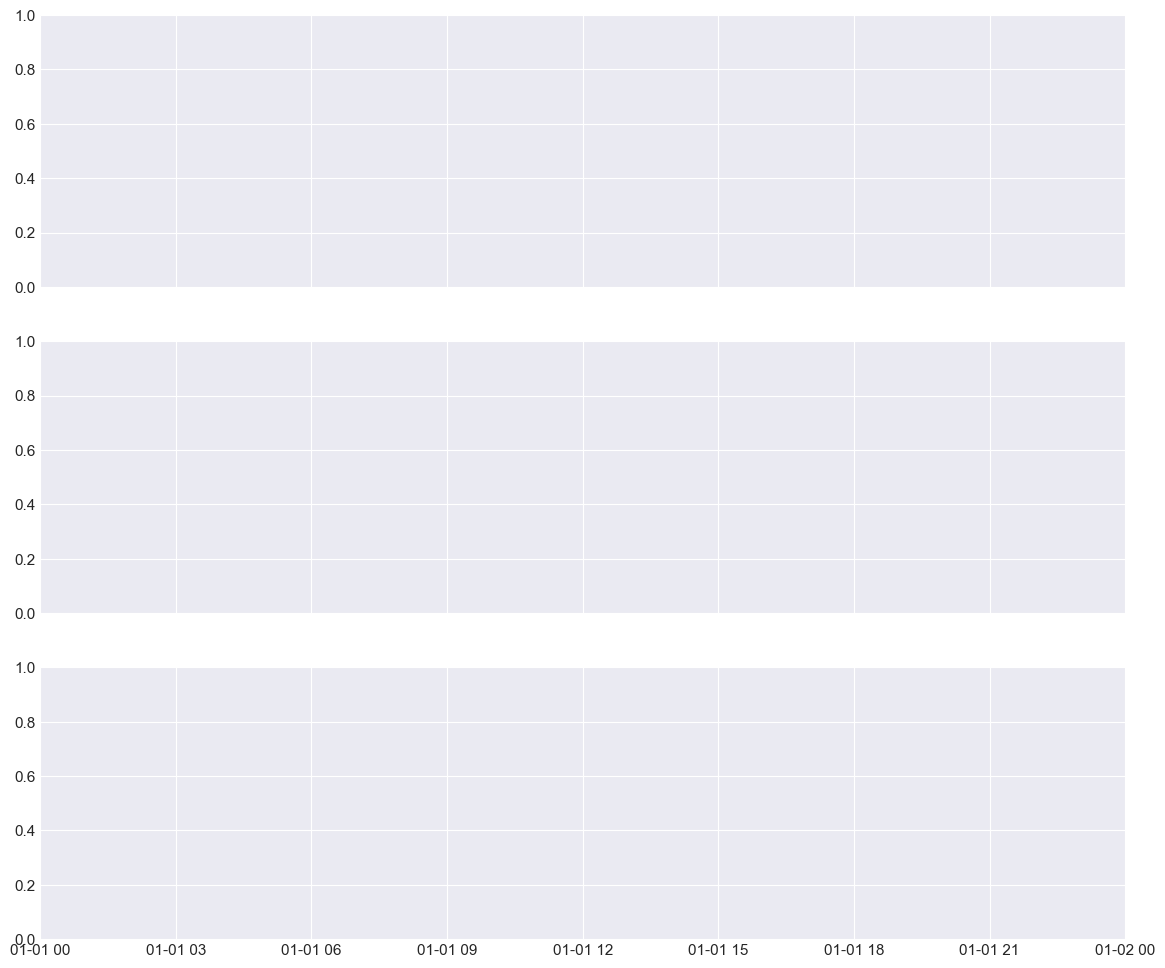

In [14]:
def calculate_rolling_metrics(portfolio_values: np.ndarray, window: int = 63) -> dict:
    """Calculate rolling performance metrics."""
    returns = pd.Series(portfolio_values).pct_change().dropna()
    
    rolling_vol = returns.rolling(window).std() * np.sqrt(252)
    rolling_sharpe = (returns.rolling(window).mean() * 252) / (returns.rolling(window).std() * np.sqrt(252))
    
    # Rolling VaR
    rolling_var = returns.rolling(window).apply(lambda x: np.percentile(x, 5))
    
    return {
        'volatility': rolling_vol,
        'sharpe': rolling_sharpe,
        'var': rolling_var
    }

# Calculate rolling metrics for risk parity (our main strategy)
rp_result = backtest_results['risk_parity']
rp_values = rp_result['portfolio_value']
rp_returns = pd.Series(rp_values).pct_change().dropna()
rp_dates = rp_result['dates'][1:]

rolling = calculate_rolling_metrics(rp_values, window=63)  # Quarterly rolling

# Create risk analysis figure
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Rolling Volatility
ax1 = axes[0]
ax1.plot(rp_dates, rolling['volatility'].values[1:], color='blue', linewidth=1.5)
ax1.axhline(y=np.mean(rolling['volatility'].dropna()), color='red', linestyle='--', 
            label=f"Mean: {np.mean(rolling['volatility'].dropna()):.2%}")
ax1.fill_between(rp_dates, 0, rolling['volatility'].values[1:], alpha=0.3)
ax1.set_ylabel('Volatility (Annualized)')
ax1.set_title('63-Day Rolling Volatility', fontweight='bold')
ax1.legend()

# Rolling Sharpe Ratio
ax2 = axes[1]
ax2.plot(rp_dates, rolling['sharpe'].values[1:], color='green', linewidth=1.5)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.axhline(y=1, color='orange', linestyle='--', label='Sharpe = 1')
ax2.axhline(y=2, color='red', linestyle='--', label='Sharpe = 2')
ax2.fill_between(rp_dates, 0, rolling['sharpe'].values[1:], 
                 where=rolling['sharpe'].values[1:] > 0, color='green', alpha=0.3)
ax2.fill_between(rp_dates, 0, rolling['sharpe'].values[1:], 
                 where=rolling['sharpe'].values[1:] < 0, color='red', alpha=0.3)
ax2.set_ylabel('Sharpe Ratio')
ax2.set_title('63-Day Rolling Sharpe Ratio', fontweight='bold')
ax2.legend()
ax2.set_ylim(-4, 6)

# Rolling VaR (95%)
ax3 = axes[2]
ax3.plot(rp_dates, rolling['var'].values[1:] * 100, color='red', linewidth=1.5)
ax3.fill_between(rp_dates, rolling['var'].values[1:] * 100, 0, color='red', alpha=0.3)
ax3.set_ylabel('VaR (%) - Daily')
ax3.set_xlabel('Date')
ax3.set_title('63-Day Rolling Value at Risk (5th Percentile)', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# VaR Analysis - Historical Simulation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Return distribution with VaR/CVaR
ax1 = axes[0]
ax1.hist(rp_returns * 100, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')

# Calculate VaR and CVaR
var_95 = np.percentile(rp_returns, 5) * 100
cvar_95 = np.mean(rp_returns[rp_returns <= np.percentile(rp_returns, 5)]) * 100

ax1.axvline(x=var_95, color='orange', linewidth=2, linestyle='--', label=f'VaR 95%: {var_95:.2f}%')
ax1.axvline(x=cvar_95, color='red', linewidth=2, linestyle='--', label=f'CVaR 95%: {cvar_95:.2f}%')
ax1.axvline(x=0, color='black', linewidth=1)
ax1.set_xlabel('Daily Return (%)')
ax1.set_ylabel('Density')
ax1.set_title('Return Distribution with VaR/CVaR', fontweight='bold')
ax1.legend()

# Monthly returns heatmap
monthly_returns = rp_returns.copy()
monthly_returns.index = rp_dates
monthly_returns = monthly_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)

# Reshape for heatmap
monthly_df = monthly_returns.to_frame('return')
monthly_df['year'] = monthly_df.index.year
monthly_df['month'] = monthly_df.index.month

pivot = monthly_df.pivot_table(values='return', index='year', columns='month', aggfunc='first')
pivot.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax2 = axes[1]
sns.heatmap(pivot * 100, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
            cbar_kws={'label': 'Return (%)'}, ax=ax2)
ax2.set_title('Monthly Returns Heatmap (%)', fontweight='bold')
ax2.set_ylabel('Year')
ax2.set_xlabel('Month')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n📊 Risk Summary Statistics:")
print(f"  • Daily VaR (95%): {var_95:.2f}%")
print(f"  • Daily CVaR (95%): {cvar_95:.2f}%")
print(f"  • Worst Daily Return: {rp_returns.min()*100:.2f}%")
print(f"  • Best Daily Return: {rp_returns.max()*100:.2f}%")
print(f"  • Skewness: {stats.skew(rp_returns):.2f}")
print(f"  • Kurtosis: {stats.kurtosis(rp_returns):.2f}")